In [1]:
import warnings, os
import numpy as np
import pandas as pd
from nbeats_keras.model import NBeatsNet as NBeatsKeras
warnings.filterwarnings(action='ignore', message='Setting attributes')
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
config = tf.compat.v1.ConfigProto() # Another Version: config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [3]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)


# simple batcher.
def data_generator(x, y, size):
    assert len(x) == len(y)
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii + size], y[ii:ii + size]))
    for batch in batches:
        yield batch

In [4]:
def MinMaxScaler(data):
  """Min Max normalizer.
  
  Args:
    - data: original data
  
  Returns:
    - norm_data: normalized data
  """
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)
  norm_data = numerator / (denominator + 1e-7)
  return norm_data

def sine_data_generation (no, seq_len, dim):
  """Sine data generation.
  
  Args:
    - no: the number of samples
    - seq_len: sequence length of the time-series
    - dim: feature dimensions
    
  Returns:
    - data: generated data
  """  
  # Initialize the output
  data = list()

  # Generate sine data
  for i in range(no):      
    # Initialize each time-series
    temp = list()
    # For each feature
    for k in range(dim):
      # Randomly drawn frequency and phase
      freq = np.random.uniform(0, 0.1)            
      phase = np.random.uniform(0, 0.1)
          
      # Generate sine signal based on the drawn frequency and phase
      temp_data = [np.sin(freq * j + phase) for j in range(seq_len)] 
      temp.append(temp_data)
        
    # Align row/column
    temp = np.transpose(np.asarray(temp))        
    # Normalize to [0,1]
    temp = (temp + 1)*0.5
    # Stack the generated data
    data.append(temp)
                
  return data

In [15]:
num_samples, time_steps, input_dim, output_dim = 50_000, 15, 5, 5
backend = NBeatsKeras(
        input_dim=input_dim,
        backcast_length=time_steps, forecast_length=5,
        stack_types=(NBeatsKeras.GENERIC_BLOCK, NBeatsKeras.GENERIC_BLOCK),
        nb_blocks_per_stack=2, thetas_dim=(4, 4), share_weights_in_stack=True,
        hidden_layer_units=64
    )

# Definition of the objective function and the optimizer.
backend.compile(loss='mae', optimizer='adam')

forecast_length = 5
backcast_length = 3 * forecast_length

'''
milk = pd.read_csv('data/milk.csv', index_col=0, parse_dates=True)
print(milk.head())
milk = milk.values.flatten()  # just keep np array here for simplicity. milk.shape = 168
'''

seq_len = 24
no, dim = 10000, 5
ori_data = sine_data_generation(no, seq_len, dim)
ori_data = np.asarray(ori_data)
ori_data = np.squeeze(ori_data)
print("real data shape:", ori_data.shape) # (no, seq_len, dim)

# x: data backcast/y: forecast generation.
x, y = [], []
for epoch in range(backcast_length, len(ori_data) - forecast_length): # range(15, len-5):
    x.append(ori_data[epoch - backcast_length:epoch]) # x = backcast (0,15), (1,16)
    y.append(ori_data[epoch:epoch + forecast_length]) # y = forecast (15,20), (16,21)
x = np.array(x)
y = np.array(y)

# split train/test.
c = int(len(x) * 0.8)
# print("the c size is: ", c) # c = 118
x_train, y_train = x[:c], y[:c] # cut the first part to be training samples (80%)
x_test, y_test = x[c:], y[c:] # use the rest part to be testing samples (20%)

# normalization.
norm_constant = np.max(x_train)
x_train, y_train = x_train / norm_constant, y_train / norm_constant
x_test, y_test = x_test / norm_constant, y_test / norm_constant
test_size = len(x_test)
# print("test_size is:", test_size) # test_size = 30

real data shape: (10000, 24, 5)


In [16]:
# check the model data shape
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7984, 15, 24, 5), (7984, 5, 24, 5), (1996, 15, 24, 5), (1996, 5, 24, 5))

In [7]:
# Train the model.
print('Training...')
backend.fit(x_train, y_train, validation_split=0.2, epochs=1000, batch_size=128)

# Save the model for later.
backend.save('n_beats_model.h5')

# Predict on the testing set (forecast).
predictions_forecast = backend.predict(x_test)
print("the prediction_forecast shape is:", predictions_forecast.shape) #shape: (30, 5, 1)
#np.testing.assert_equal(predictions_forecast.shape, (test_size, backend.forecast_length, output_dim))

# Predict on the testing set (backcast).
predictions_backcast = backend.predict(x_test, return_backcast=True)
print("the prediction_backcast shape is:", predictions_backcast.shape) #shape: (30, 15, 1)
#np.testing.assert_equal(predictions_backcast.shape, (test_size, backend.backcast_length, output_dim))

# Load the model.
model_2 = NBeatsKeras.load('n_beats_model.h5')
predicts = model_2.predict(x_test)
print("the reloaded prediction_shape is:", predicts.shape) #shape: (30, 5, 1)
#np.testing.assert_almost_equal(predictions_forecast, model_2.predict(x_test))

Training...
Epoch 1/1000
1200/1200 [==============================] - 29s 10ms/step - loss: 0.3119 - val_loss: 0.3010
Epoch 2/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3015 - val_loss: 0.3010
Epoch 3/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3012 - val_loss: 0.3024
Epoch 4/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3013 - val_loss: 0.3008
Epoch 5/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3007 - val_loss: 0.3008
Epoch 6/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3012 - val_loss: 0.3010
Epoch 7/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3007 - val_loss: 0.3009
Epoch 8/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3008 - val_loss: 0.3008
Epoch 9/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3005 - val_loss: 0.3011
Epoch 10/1000
1200/1200 [=========================

Epoch 79/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3009 - val_loss: 0.3006
Epoch 80/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3007 - val_loss: 0.3007
Epoch 81/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3009 - val_loss: 0.3007
Epoch 82/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3012 - val_loss: 0.3007
Epoch 83/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3005 - val_loss: 0.3006
Epoch 84/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3012 - val_loss: 0.3006
Epoch 85/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3007 - val_loss: 0.3006
Epoch 86/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3004 - val_loss: 0.3006
Epoch 87/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3006 - val_loss: 0.3006
Epoch 88/1000
1200/1200 [==============================

1200/1200 [==============================] - 8s 7ms/step - loss: 0.3007 - val_loss: 0.3006
Epoch 157/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3007 - val_loss: 0.3006
Epoch 158/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3005 - val_loss: 0.3007
Epoch 159/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3007 - val_loss: 0.3006
Epoch 160/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3009 - val_loss: 0.3006
Epoch 161/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3009 - val_loss: 0.3006
Epoch 162/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3009 - val_loss: 0.3006
Epoch 163/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3008 - val_loss: 0.3005
Epoch 164/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3008 - val_loss: 0.3006
Epoch 165/1000
1200/1200 [==============================] - 8

1200/1200 [==============================] - 8s 7ms/step - loss: 0.3008 - val_loss: 0.3005
Epoch 234/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3005 - val_loss: 0.3006
Epoch 235/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3004 - val_loss: 0.3007
Epoch 236/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3005 - val_loss: 0.3007
Epoch 237/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3006 - val_loss: 0.3006
Epoch 238/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3005 - val_loss: 0.3006
Epoch 239/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3006 - val_loss: 0.3005
Epoch 240/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3008 - val_loss: 0.3006
Epoch 241/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3002 - val_loss: 0.3006
Epoch 242/1000
1200/1200 [==============================] - 8

1200/1200 [==============================] - 8s 7ms/step - loss: 0.3008 - val_loss: 0.3005
Epoch 311/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3005 - val_loss: 0.3006
Epoch 312/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3001 - val_loss: 0.3006
Epoch 313/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3005 - val_loss: 0.3006
Epoch 314/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3006 - val_loss: 0.3006
Epoch 315/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3009 - val_loss: 0.3006
Epoch 316/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3009 - val_loss: 0.3006
Epoch 317/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3007 - val_loss: 0.3006
Epoch 318/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3012 - val_loss: 0.3005
Epoch 319/1000
1200/1200 [==============================] - 8

1200/1200 [==============================] - 8s 7ms/step - loss: 0.3007 - val_loss: 0.3008
Epoch 388/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3008 - val_loss: 0.3006
Epoch 389/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3003 - val_loss: 0.3006
Epoch 390/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3006 - val_loss: 0.3005
Epoch 391/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3006 - val_loss: 0.3005
Epoch 392/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3007 - val_loss: 0.3007
Epoch 393/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3010 - val_loss: 0.3006
Epoch 394/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3006 - val_loss: 0.3006
Epoch 395/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3007 - val_loss: 0.3007
Epoch 396/1000
1200/1200 [==============================] - 8

1200/1200 [==============================] - 8s 6ms/step - loss: 0.3005 - val_loss: 0.3005
Epoch 465/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3005 - val_loss: 0.3006
Epoch 466/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3007 - val_loss: 0.3006
Epoch 467/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3008 - val_loss: 0.3006
Epoch 468/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3005 - val_loss: 0.3005
Epoch 469/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3006 - val_loss: 0.3005
Epoch 470/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3010 - val_loss: 0.3006
Epoch 471/1000
1200/1200 [==============================] - 8s 6ms/step - loss: 0.3004 - val_loss: 0.3006
Epoch 472/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3004 - val_loss: 0.3005
Epoch 473/1000
1200/1200 [==============================] - 8

1200/1200 [==============================] - 8s 7ms/step - loss: 0.3008 - val_loss: 0.3006
Epoch 542/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3010 - val_loss: 0.3007
Epoch 543/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3010 - val_loss: 0.3007
Epoch 544/1000
1200/1200 [==============================] - 8s 6ms/step - loss: 0.3008 - val_loss: 0.3006
Epoch 545/1000
1200/1200 [==============================] - 8s 6ms/step - loss: 0.3005 - val_loss: 0.3006
Epoch 546/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3005 - val_loss: 0.3006
Epoch 547/1000
1200/1200 [==============================] - 8s 6ms/step - loss: 0.3007 - val_loss: 0.3006
Epoch 548/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3006 - val_loss: 0.3006
Epoch 549/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3004 - val_loss: 0.3006
Epoch 550/1000
1200/1200 [==============================] - 8

1200/1200 [==============================] - 8s 7ms/step - loss: 0.3006 - val_loss: 0.3005
Epoch 619/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3010 - val_loss: 0.3006
Epoch 620/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3004 - val_loss: 0.3006
Epoch 621/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3009 - val_loss: 0.3006
Epoch 622/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3009 - val_loss: 0.3006
Epoch 623/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3007 - val_loss: 0.3005
Epoch 624/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3004 - val_loss: 0.3006
Epoch 625/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3008 - val_loss: 0.3007
Epoch 626/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3009 - val_loss: 0.3006
Epoch 627/1000
1200/1200 [==============================] - 8

1200/1200 [==============================] - 8s 6ms/step - loss: 0.3008 - val_loss: 0.3005
Epoch 696/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3005 - val_loss: 0.3008
Epoch 697/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3006 - val_loss: 0.3005
Epoch 698/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3006 - val_loss: 0.3005
Epoch 699/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3012 - val_loss: 0.3006
Epoch 700/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3007 - val_loss: 0.3005
Epoch 701/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3007 - val_loss: 0.3005
Epoch 702/1000
1200/1200 [==============================] - 8s 6ms/step - loss: 0.3006 - val_loss: 0.3005
Epoch 703/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3006 - val_loss: 0.3006
Epoch 704/1000
1200/1200 [==============================] - 8

1200/1200 [==============================] - 8s 7ms/step - loss: 0.3006 - val_loss: 0.3006
Epoch 773/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3005 - val_loss: 0.3006
Epoch 774/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3008 - val_loss: 0.3006
Epoch 775/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3007 - val_loss: 0.3005
Epoch 776/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3011 - val_loss: 0.3007
Epoch 777/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3007 - val_loss: 0.3006
Epoch 778/1000
1200/1200 [==============================] - 8s 6ms/step - loss: 0.3007 - val_loss: 0.3006
Epoch 779/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3006 - val_loss: 0.3006
Epoch 780/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3007 - val_loss: 0.3007
Epoch 781/1000
1200/1200 [==============================] - 8

1200/1200 [==============================] - 8s 7ms/step - loss: 0.3004 - val_loss: 0.3006
Epoch 850/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3008 - val_loss: 0.3006
Epoch 851/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3009 - val_loss: 0.3005
Epoch 852/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3006 - val_loss: 0.3005
Epoch 853/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3004 - val_loss: 0.3006
Epoch 854/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3007 - val_loss: 0.3006
Epoch 855/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3006 - val_loss: 0.3006
Epoch 856/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3003 - val_loss: 0.3006
Epoch 857/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3004 - val_loss: 0.3006
Epoch 858/1000
1200/1200 [==============================] - 8

1200/1200 [==============================] - 8s 7ms/step - loss: 0.3005 - val_loss: 0.3005
Epoch 927/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3007 - val_loss: 0.3005
Epoch 928/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3007 - val_loss: 0.3006
Epoch 929/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3008 - val_loss: 0.3006
Epoch 930/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3006 - val_loss: 0.3007
Epoch 931/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3005 - val_loss: 0.3006
Epoch 932/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3002 - val_loss: 0.3005
Epoch 933/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3008 - val_loss: 0.3006
Epoch 934/1000
1200/1200 [==============================] - 8s 7ms/step - loss: 0.3007 - val_loss: 0.3006
Epoch 935/1000
1200/1200 [==============================] - 8

/home/stufs1/zuwang/anaconda3/envs/nbeats/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


the prediction_forecast shape is: (47996, 5, 5)
the prediction_backcast shape is: (47996, 15, 5)
the reloaded prediction_shape is: (47996, 5, 5)


In [8]:
predicts.shape, y_test.shape

((47996, 5, 5), (47996, 5, 5))

In [9]:
predicts[0].shape, y_test[0].shape

((5, 5), (5, 5))

In [10]:
mean_absolute_error(predicts[0], y_test[0])

0.38564227469937223

In [11]:
num_sample = len(x_test)

MAE_temp = 0.0
MSE_temp = 0.0

for i in range(num_sample):
    MAE_temp = MAE_temp + mean_absolute_error(y_test[i], predicts[i])
    MSE_temp = MSE_temp + mean_squared_error(y_test[i], predicts[i])

predictive_score_mae = MAE_temp/num_sample
predictive_score_mse = MSE_temp/num_sample
print("predictive_score_mae:", predictive_score_mae)
print("predictive_score_mse:", predictive_score_mse)

predictive_score_mae: 0.3005697242592733
predictive_score_mse: 0.13210614825862768


In [12]:
predicts[0].shape

(5, 5)

In [13]:
ff, xx, yy = predicts[0] * norm_constant, x_test[0] * norm_constant, y_test[0] * norm_constant
ff.shape, xx.shape, yy.shape

((5, 5), (15, 5), (5, 5))

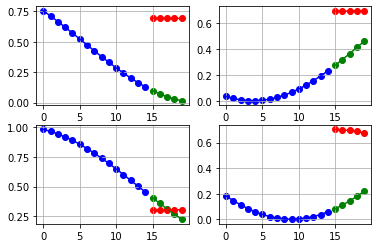

In [14]:
subplots = [221, 222, 223, 224]
plt.figure(1)
for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
    p1 = np.expand_dims(predicts[i][:,0], axis=-1)
    x1 = np.expand_dims(x_test[i][:,0], axis=-1)
    y1 = np.expand_dims(y_test[i][:,0], axis=-1)
    ff, xx, yy = p1 * norm_constant, x1 * norm_constant, y1 * norm_constant
    plt.subplot(subplots[plot_id])
    plt.grid()
    plot_scatter(range(0, backcast_length), xx, color='b')
    plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
    plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
plt.savefig("nbeats-REAL-predictions-sines.png", dpi=300)
plt.show()